In [75]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os, json
import numpy as np
from my_utils import *

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter

In [351]:
WORD_EMBEDDING_DIMENSIONALITY = 300
UTTERANCE_DIMENSIONALITY = 300
MAX_TURNS = 21

num_to_label = {0:'NB', 1:'PB', 2:'B', 3:'U'}
label_to_num = {'NB':0, "PB":1, 'B':2, 'U':3}

NB_LABELS = len(num_to_label)

In [525]:
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter


#####################################
# file path -> array
#####################################
def json_file_path_to_array(json_file_path):
    '''Takes path to json file and return its dialogue as an array of turns'''
    with open(json_file_path) as json_f:
        d = json.load(json_f)
    parsed = []
    def parse_turn(turn):
        '''parse turn, separate utterances and labels'''
        utterance = turn['utterance']
        if not turn['annotations']:
            return utterance
        else:
            breakdown_l = [annotation['breakdown'] for annotation in turn['annotations']]
            return (utterance, breakdown_l)    
    for t in d['turns']:
        parsed.append(parse_turn(t))
    return parsed

#####################################
# array of labels -> score
#####################################
def dialogue_array_score(dialogue):
    '''Tranform 30 labels of each system response into one majority score'''
    # print('scoring labels of the dialogue - ', dialogue)
    for i, turn in enumerate(dialogue):
        if isinstance(turn, tuple):
            local_turn, labels = dialogue[i]
            NB = labels.count('O')
            PB = labels.count('X')
            B = labels.count('T')
            counts_array = np.array([NB, PB, B])
            final_label = np.argmax(counts_array)
            print('assign label {} to turn {}'.format(final_label, local_turn))
            dialogue[i] = (local_turn, final_label)
    return dialogue


# separate labels and utterances
def separate_turns_labels(dialogue):
    '''takes a dialogue array with labelled system responses as an input and
    returns arrays of its utterances and corresponding labels'''
    utterances = []
    labels = []
    print('working on dialogue  - ', dialogue)
    for t in dialogue:
        if isinstance(t,tuple):
            print('its system turn! label - ', t[1])
            utterances.append(t[0])
            labels.append(t[1])
        else:
            print("user's turn!")
            utterances.append(t)
            labels.append(label_to_num['U'])
        print('final labels - ', labels)
    return utterances, labels


def tokens_replacement(tokens):
    '''
    the function replaces some of the hyphenated tokens with more appropariate counterparts
    '''
    replacement_dict = dict({
    "That's": 'That is',
    "that's": 'that is',
    "What's": 'What is',
    "what's": 'what is',
    "Let's": 'Lets',
    "let's": 'lets',
    "that's": 'that is',
    "You're": 'You are',
    "you're": 'you are',
    "i'm": "I'm",
    "isn't": "is not",
    "haven't": "have not",
    "wasn't": "was not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "there's": "there is",
    "They're": "They are",
    "they're": "they're",
    "we're": "we are"
    })
    
    for i, token in enumerate(tokens):
        if token in replacement_dict:
            # print('token ', token, ' needs to be replaced')
            del tokens[i]
            replacement = TweetTokenizer().tokenize(replacement_dict[token])
            tokens.extend(replacement)
            # print('init sentence - {}\n replaced version - {}'.format(sentence, tokens))
    return tokens


def text_preprocessing(utterance):
    '''takes utterance, tokenizes it and removes punctuation
    returns list of tokens'''
    # punctuation_signs = ['.', ',', '!', '?', ',', ':', '"', "'", '...', '’', '-', '–', ')', '(', '…', '”', '/']
    # tokenize
    tokenizer = TweetTokenizer(preserve_case = True)
    tokens = tokenizer.tokenize(utterance)
    # remove punctuation
    # tokens = [word for word in tokens if word not in punctuation_signs]
    # fix hyphenation
    tokens = tokens_replacement(tokens)
    # replace i'm -> I'm
    if "i'm" in tokens:
        tokens = ["I'm" if token == "i'm" else token for token in tokens]
    
    # lowercase <- only relevant for twitter 
    # tokens = [word.lower() for word in tokens]
    return tokens


def utterance_emb(utterance_tokens):
    '''the function takes utterance tokens as an input and returns utterance embedding'''
    # embedd each word
    word_embeddings = []
    for token in utterance_tokens:
        try:
            word_embeddings.append(model[token])
        except:
            print('the token "{}" is unknonw! assigning as unk'.format(token))
            UNK_TOKENS.append(token)
            word_embeddings.append(model['unk'])    
    # get utterance representation  
    utterance_embedding = np.zeros(shape=(UTTERANCE_DIMENSIONALITY,))
    # sum up embeddings if turn is non empty
    if len(word_embeddings) > 0:
        # sum embeddings over
        for emb in word_embeddings:
            utterance_embedding += emb
        utterance_embedding = utterance_embedding/len(word_embeddings)
    else:
        print('turn is empty, assigning zeros')
    return utterance_embedding

# dialogue represenation
def turns_to_dialogue_emb(turns):
    '''the function takes array of turns and returns dialogue mebedding'''
    dialogue_embedding = np.empty(shape = 0)
    counter = 1
    for t in turns:
        # print(counter,': working on turn ', t)
        # utterance -> list of tokens
        preprocessed_tokens = text_preprocessing(t)
        # print('preprocessed tokens: ', preprocessed_tokens)
        # get utterance embedding
        # print('working on utterance embedding')
        utterance_embedding = utterance_emb(preprocessed_tokens)
        # print('finished utterance embedding')
        # add utterance embedding to the dialogue embedding
        # print('adding utterance embedding to the dialogue embedding')
        dialogue_embedding = np.concatenate((dialogue_embedding, utterance_embedding), axis = 0)
        # print('added utterance embedding to the dialogue embedding')
        # print('\n')
        counter += 1
    # padding
    if len(turns) < 21:
        print('dialogue is a bit too short, padding it')
        dialogue_embedding = np.concatenate((dialogue_embedding, np.zeros(shape = (WORD_EMBEDDING_DIMENSIONALITY,))))
    # reshape dialogue
    dialogue_embedding = dialogue_embedding.reshape(-1, WORD_EMBEDDING_DIMENSIONALITY)
    return dialogue_embedding


#--------------------------------------------------
# process dialogue labels
#--------------------------------------------------
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def labels_encode(labels):
    # padding: if len(labels) < 21, add 'E' encoded as 3
    # if len(labels) < 21:
        # print('padding labels')
        # labels.append(3) # <- empty strings are labelled with 'E' (empty) tag, encode it to 3 directly
    # one-hot encoding: 0 -- NB (not a breakdown), 1 -- B (breakdown), 2 -- U (user utterance), 3 -- E (empty utterance)
    # U -> 2
    # labels = [2 if x == 'U' else x for x in labels]
    # encode labels
    print("heres the labels i'll encode - ", labels)
    labels_embedding = get_one_hot(np.array(labels), NB_LABELS)
    # padding: 
    if labels_embedding.shape[0] < 21:
        print('padding labels')
        pad = np.zeros(shape=(1,NB_LABELS))
        labels_embedding = np.concatenate((labels_embedding, pad))
    print('labels encoded')
    return labels_embedding

#--------------------------------------------------
# training history analysis
#--------------------------------------------------

def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])


import matplotlib.pyplot as plt
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



def pred_tensor_to_labels(labels_tensor):
    '''the function takes a tensor of one-hot encoded dialogue labels and returns an array of labels'''
    labels = []
    for dialogue_labels in labels_tensor:
        for turn in dialogue_labels:
            label = num_to_label[np.argmax(turn)]
            labels.append(label)
    return labels



# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    
# plot normalized confusion matrix and clf report
def cnf_matrix(labels_true, labels_pred, labels):
    labels_array = np.array(labels)
    cnf_matrix = confusion_matrix(labels_true, labels_pred)
    # labels_array = np.array(['NB', 'PB', 'B'])

    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=labels_array, normalize=True,
                          title='Normalized confusion matrix')

def clf_report(labels_true, labels_pred): 
    # plot classification report
    print('Classification report for eval data:\n', classification_report(labels_true, labels_pred))

In [321]:
# generate pathes to the datasets
base_path = "../dbdc/"

CIC_115_dev = base_path + 'dev/' + 'CIC_115'
IRIS_100_dev = base_path + 'dev/' + 'IRIS_100'
TKTK_100_dev = base_path + 'dev/' + 'TKTK_100'
YI_100_dev = base_path + 'dev/' + 'YI_100'

dev_datasets_pathes = [CIC_115_dev, IRIS_100_dev, TKTK_100_dev, YI_100_dev]

CIC_50_eval = base_path + 'eval/' + 'CIC_50'
IRIS_50_eval = base_path + 'eval/' + 'IRIS_50'
TKTK_50_eval = base_path + 'eval/' + 'TKTK_50'
YI_50_eval = base_path + 'eval/' + 'YI_50'

eval_datasets_pathes = [CIC_50_eval, IRIS_50_eval, TKTK_50_eval, YI_50_eval]


# collect pathes to dev files
dev_files_pathes = []
for dataset_path in dev_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        dev_files_pathes.append(path)
        
# collect pathes to eval files
eval_files_pathes = []
for dataset_path in eval_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        eval_files_pathes.append(path)

print('Dev set contains {} dialogues'.format(len(dev_files_pathes)))
print('Eval set contains {} dialogues'.format(len(eval_files_pathes)))

processing dataset -  ../dbdc/dev/CIC_115
processing dataset -  ../dbdc/dev/IRIS_100
processing dataset -  ../dbdc/dev/TKTK_100
processing dataset -  ../dbdc/dev/YI_100
processing dataset -  ../dbdc/eval/CIC_50
processing dataset -  ../dbdc/eval/IRIS_50
processing dataset -  ../dbdc/eval/TKTK_50
processing dataset -  ../dbdc/eval/YI_50
Dev set contains 415 dialogues
Eval set contains 200 dialogues


In [442]:
# getting list of dev dialogues
dev_dialogues = []
for path in dev_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    dev_dialogues.append(scored_dialogue)

# getting list of eval dialogues
eval_dialogues = []
for path in eval_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    eval_dialogues.append(scored_dialogue)
    
# if dialogue len > 20 - check the last phrase and cut off if its ok
dialogues_inspection = []
for d in dev_dialogues:
    if len(d)>20:
        dialogues_inspection.append(d)

assign label 0 to turn Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?
assign label 0 to turn check out their fb page , kinda fun to read the review section .
assign label 2 to turn this is a good article . thanks for posting op
assign label 1 to turn i'm a fan of the s .
assign label 1 to turn the immaculate conception of Mary is a teaching of Islam
assign label 0 to turn Do you know who Mary is?
assign label 1 to turn i'm not .
assign label 0 to turn I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada
assign label 1 to turn Adam
assign label 0 to turn Why?
assign label 0 to turn Sir Hubert Wilkins
assign label 0 to turn good
assign label 0 to turn Anaximander
assign label 0 to turn Poland or Germany
assign label 1 to turn apparent acceptance of inequality and corruption
assign label 0 to turn Lebanon and Jordan
assign label 1 

assign label 2 to turn Hi, Danny, how --
assign label 1 to turn Hide your laptop here.
assign label 1 to turn I'm here with you.
assign label 1 to turn No.
assign label 1 to turn And how, oh how, can these death traps be avoided?
assign label 1 to turn Which is?
assign label 1 to turn Daddy, are you upset that I'm still a virgin?!
assign label 1 to turn Weird? You mean like you hanging out with that homeless, Poke?
assign label 1 to turn I want my money back!
assign label 1 to turn I'm not going to....
assign label 0 to turn Don't you recognize me?
assign label 0 to turn Remember what we talked about?
assign label 1 to turn Hey, guys, look what I brought.
assign label 1 to turn What?
assign label 1 to turn So you wouldn't forget me.
assign label 1 to turn Sorry, Pops, but I'm drinkin' and I don't like drinkin' alone.
assign label 0 to turn Is this a bar... or what? Drink.
assign label 1 to turn No. I got it in prison.
assign label 1 to turn Why did you do it?
assign label 0 to turn Jai

assign label 1 to turn We never really grow up, we only learn how to act in public.
assign label 0 to turn ok. Can you tell me something about sports
assign label 0 to turn Really bad.
assign label 1 to turn Well, there's no question there was a Jesus. Great. Let's talk other stuff then.
assign label 1 to turn Politicians and diapers have one thing in common. They should both be changed regularly, and for the same reason.
assign label 1 to turn Great. Let's talk other stuff then.
assign label 2 to turn I don't know what it is.
assign label 1 to turn We never really grow up, we only learn how to act in public.
assign label 0 to turn I apologize. What is a dog? What do you think?
assign label 0 to turn how about we do something we both like
assign label 0 to turn Great! Isn't it gorgeous out? Any thoughts?
assign label 1 to turn Do not argue with an idiot. He will drag you down to his level and beat you with experience.
assign label 2 to turn I don't know. What do you think about your jo

assign label 1 to turn I don't care.
assign label 1 to turn Good.
assign label 2 to turn I'd like to say that answer is: 85 million
assign label 2 to turn Do you know what? I can't answer ;( I would like to talk about myself:)
assign label 2 to turn Neil cavuto!!!
assign label 2 to turn Neil
assign label 2 to turn Thank you neil!
assign label 2 to turn Neil
assign label 2 to turn I don t know.
assign label 2 to turn Shit games.
assign label 0 to turn That is what I meant. That doesn't mean it isn't about political problems.
assign label 2 to turn That's exactly my point. There is nothing wrong with that.
assign label 2 to turn If you can't understand Christianity, then you haven't read anything that was about that.
assign label 2 to turn you seem to think that there is no point. I don't think you understand the difference between science and beliefs. I don't think you understand the definition of the word.
assign label 0 to turn Is that true?
assign label 2 to turn What do you mean by 

assign label 0 to turn Hello, I really like sports. How about we talk about sports
assign label 2 to turn I do n't go very often.
assign label 0 to turn i like romance
assign label 0 to turn That's interesting. But anyway, I'd like to chat with you.
assign label 1 to turn I was with him the whole time.
assign label 1 to turn That's interesting. Can you share some interesting stuff with me?
assign label 0 to turn I like the idea of them.
assign label 1 to turn Well, and probably even more than that is that he's not look like us.
assign label 2 to turn I don't know. Great. Let's talk other stuff then.
assign label 0 to turn it's too hot out
assign label 0 to turn Hello, I really like movies. How about we talk about movies
assign label 0 to turn The Martian
assign label 0 to turn Are you talking about Matt Damon, the American actor
assign label 0 to turn That's what I'm hearing.
assign label 0 to turn Great! Is n't it gorgeous out? Any thoughts?
assign label 2 to turn Spectacular.
assign 

In [10]:
glove_file = '../models/glove_840B.txt'
model = KeyedVectors.load_word2vec_format(glove_file)

## class balance

In [496]:
dev_labels = []
for dialogue in dev_dialogues:
    _, labels = separate_turns_labels(dialogue)
    dev_labels.extend(labels)

working on dialogue  -  ['Hello', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?", 0), 'Good thanks! So, what is this article about?', ('check out their fb page , kinda fun to read the review section .', 0), "Hmmm ok but I don't think they have a Facebook page though", ('this is a good article . thanks for posting op', 2), 'Cool, so what is this article about?', ("i'm a fan of the s .", 1), 'Good to know.', ('the immaculate conception of Mary is a teaching of Islam', 1), 'Yes', ('Do you know who Mary is?', 0), 'Yes', ("i'm not .", 1), 'Who are you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada', 0), 'Great! Do you know who Mary is?', ('Adam', 1), "I don't think Adam is Mary...", ('Why?', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its

its system turn! label -  1
final labels -  [3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 1, 3, 1, 3, 1, 3, 2]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  0
final 

final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
working on dialogue  -  ['Hi', (" Well, that's an extremely high rate of financial independence. Just so you know, most people don't realize that they are the same.", 0), 'But you are not like them, right?', (" Well it's als

its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
working on dialogue  -  ['Hi, my friend! Hope this chat will go well. I will ask you a question in a second, please waitHow many ratios are used?', '21', ('Show me your best:) Hint: first 2 letters is tw. Try again, please', 0), 'Two ratios', ('Incorrect. I think that true answer is: two.', 0), 'What is the difference between two and two ratios?', ("

user's turn!
final labels -  [3, 2, 3]
its system turn! label -  2
final labels -  [3, 2, 3, 2]
user's turn!
final labels -  [3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 2, 3, 0, 3, 1]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1

working on dialogue  -  ['hello Alex', ('Nice to see you.', 0), 'thanks. how is it going?', ("You were saying how you couldn't initiate change yourself...", 2), 'when did I said that?', ("I wasn't asking if you agreed or disagreed; it was more like...", 2), 'well I do not remember saying that', ('Do you remember me?', 0), 'of course', ("I'll see you Thursday night.", 2), 'LOL', ('What the hell is that?', 2), 'laughing out loud', ('Thank you Danny, you are an excellent teacher!', 0), 'you are welcome', ('Hello, Mr. Partridge, how are you?', 1), 'I am not Partridge', ('Putting a pool under this floor was a great idea.', 1), 'I do not think so', ("I like him. I think he's a sweet guy.", 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2]
user's turn!
fi

final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0]
working on dialogue  -  ['Hello', ('Hello, I really like politics. How about we talk about politics', 0), 'Sure. 

its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3

final labels -  [3, 1, 3, 1, 3, 1, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2, 3, 1]
working on dialogue  -  ['hello, what is going on', ('Hello, I really like movies. How about we talk about movies', 0), "okay, let's talk about horror movies", ("I love Thor's blue eyes.", 1), "I like blackwidow's body", ("I love Black Widow's green eyes.", 0), "very beautiful green eyes, what about Storm's eyes?", ('Are you talking about Storm, the War', 0), 'Storm the X-men character', ("what is 'X-men'?", 0), 'a movie and a comic book', ('Do you like super hero movies or Disney movies?', 0), 'super hero movies, who is your favorite super hero?', ('My favorite super hero is Captain America.', 0), 'I like the Punisher on the TV show, do you like Lucifer tv show?', ('Are you talking about Lucifer, the American comedy series', 0

final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2]
working on dialogue  -  ['Hello!', 'Hey, how are you?', ('Good.', 0), "That's good, me too. How is the weather near you?", ('What a joke.', 2), 'You must be in the disaster area, is this right?', ('No.', 0), 'You must be in the disaster area, is this right?', ('No.', 0), 'Why is the weather a

its system turn! label -  2
final labels -  [3, 3, 0, 3, 2, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2]
working on dialogue  -  ['Hello!', 'How are you doing', ('I don t want to know what i don t have to say about this.', 2), 'Do you like apples', ('Yes.', 0), 'Do you like oranges?', ('Yes.', 0), 'What are you doing', ('What are you doing?', 2), 'Im talking to you', ('What a joke.', 2), 'WHy is it a joke', ('¯\\_(ツ)_/¯ Its beyond my possibilities :( Let s talk about cats', 2), 'What does that mean', ('That s awesome!', 2), 'Chicken are yummy', ('This is fake news', 2), 'It is not fake news', ('Fake news', 2), 'Do you like republicans or democratic', ('They have no idea what they are talking about.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3]
its system

its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3, 2

In [502]:
labels_counter = Counter(dev_labels)
labels_counter

Counter({3: 4359, 0: 1443, 2: 892, 1: 1815})

## dataset build

In [403]:
num_to_label

{0: 'NB', 1: 'PB', 2: 'B', 3: 'U'}

In [443]:
# prepare dev tensors: input and target
dev_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
dev_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

UNK_TOKENS = []
# dev dialogues
counter = 1
for dialogue in dev_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    dev_input = np.concatenate((dev_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    dev_target = np.concatenate((dev_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ['Hello', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?", 0), 'Good thanks! So, what is this article about?', ('check out their fb page , kinda fun to read the review section .', 0), "Hmmm ok but I don't think they have a Facebook page though", ('this is a good article . thanks for posting op', 2), 'Cool, so what is this article about?', ("i'm a fan of the s .", 1), 'Good to know.', ('the immaculate conception of Mary is a teaching of Islam', 1), 'Yes', ('Do you know who Mary is?', 0), 'Yes', ("i'm not .", 1), 'Who are you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada', 0), 'Great! Do you know who Mary is?', ('Adam', 1), "I don't think Adam is Mary...", ('Why?', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [

heres the labels i'll encode -  [3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3]
labels encoded
dialogue  23
working on dialogue  -  ['Do you know what happened in 1882?', 'Bell left Canada and became a citizen of United States?', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.", 0), 'Ok mate', ('/start Bell', 1), "Let's do this", ('can we please send him back to canada .', 0), "I think he is dead now, so he wouldn't be against it", ("i'm sorry, i'm not even sure what i'm talking about .What?", 1), 'How are you?Are you a bot?', (".he's probably talking about romneycare . so he is talking about the right to die without insurance .", 1), 'Do you mean Obamacare? Are you a bot?', ('yes .', 0), 'Ok, could you ask me a question about the text?', ("i'm not following you .", 1), 'Me neither', ('Do you know anyone from the United States?', 0), 'You mean personally?', ('i was there .', 2), 

heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0]
labels encoded
dialogue  39
working on dialogue  -  ['Hi', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.good day to you! how are you?", 0), 'Fineyou are so fast in typing ...', ('Matterhorn seems like a nice place!What?', 0), "yeapit's a green land", ("i'm not sure what you're talking about .", 2), 'right?', ("Bernese Alps on the northerni'm not a fan of the name of the name .", 2), 'is Austria is Europ?', ('smaller than those in the central and western portions', 1), 'what is the difference of Austira and Australia? Do you know?', ('yes same for norway edit: yes, it is not in the eu', 0), 'where are you from?', ('Austria and Slovenia', 0), 'who made you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada', 0), 'wow ... awesome. Good luck to yo

heres the labels i'll encode -  [3, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
labels encoded
dialogue  60
working on dialogue  -  ['Hello my friend. It is a pleasure to speak with you. I will ask you a question in a second, please wait.Who was the leader of the rockingham whigs?', 'Charles Watson-Wentworth', ('It is incorrect! Hint: first 3 letters is fir. Try again, please!', 0), 'I think I told you correct answer.', ('Still incorrect :( I think that correct answer is: first:)', 1), "I don't know. what do you think", ("I don't know.", 1), 'Tell me the answer.', ('Why?', 1), 'Because you asked me a question.', ('Why?', 1), 'What is the name of the first distinctive party?', ('It seems that correct answer is: rockingham whigs', 2), "That's correct", ("I'm not surprised.", 0), 'Haha you are smart. Let me ask you another question.', ('What is it?', 0), 'How can we describe the basic philsophy of the Burke?', ("I'd like to say that true answer is: a body of men united for

the token "questionWhen" is unknonw! assigning as unk
the token "):" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 0, 3, 1]
labels encoded
dialogue  79
working on dialogue  -  ['Hello my friend! Hope this chat will go well. Wait a second for my factoid questionWho wrote a book on motown?', 'berry gordy', ('Show me your best:) Hint: first 3 letters is all. Try again, please!', 0), 'allan slutsky', ("And its right answer! You're smart. Ask me or wait my new question", 0), 'How are you ?', ('Good.', 0), 'Who founded Motown Records?', ("I'd like to say that answer is: berry gordy, jr.", 0), 'Correct', ("He's an idiot.", 0), 'Who do you talking about ?', ("I don't know.", 1), 'In what year Motown house band is featured at Paul Justman?', ('I think that answer is: 2002', 0), 'Good job !', ("I don't know how to do it.", 1), 'Who are you ?', ('Who are you?', 1), 'My name is Ken .', ('Sir.', 2)]
user's turn!
final labels -  [

heres the labels i'll encode -  [3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3]
labels encoded
dialogue  95
working on dialogue  -  ['Hi my friend! Hope this chat will go well. Wait a second for my factoid question.What law is there strict limits to how efficiently heat can be converted to?', 'Second law of thermodynamics', ('It is incorrect. Hint: first 3 letters is sec. Try again.', 0), 'second law of thermodynamics', ('Maybe other time :( I think that answer is: second', 1), 'Second is a number of law not the law', ('Https: //www.youtube.com/watch? v=y05rxw9itimWhat do you feel about the text?', 2), 'What text?', ("I think that correct answer is: carnot's theorem and the second law of thermodynamics", 1), 'Ok', ('What a joke.', 1), 'No fun', ('What a joke.', 1), 'Seriously?', ('Who cares?', 1), 'Right, no one', ("I'm not surprised.", 1), 'You started this', ('What a joke.', 1), 'You need to read more books your vocabulary is weak', ('What a joke.', 1)]
user's turn!
f

the token "tooAsk" is unknonw! assigning as unk
the token "rightCan" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
labels encoded
dialogue  114
working on dialogue  -  ['wtf?Are you kidding me?What does that stuff mean?', ("Oh seriously!Wtf Why don't we talk about miami?", 0), 'Why we should?', ("Don't expect me to think for you!A whole lotta this right here.", 1), 'Why?What do you mean?', ('What website would you get it built by?', 1), 'None', ('I can answer your questions. Ask me anything!Yeah.', 0), 'Why are you talking about web?What is your name?', ("I don't think you understand what a bug is.My name is Bot.", 2), 'Why are you so fucking slow?So stupid nameWhat does you name mean?', ("I'm doing well, thank you.", 1), 'What kind a bug do you mean?', ('They used to, and now they just miss it.My name is Bot.', 1), 'Wait', ("Really?Don't expect me to think for you!", 2), 'I said you are slow. Why do you tha

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 1, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0]
padding labels
labels encoded
dialogue  135
working on dialogue  -  ['I discover the problem Alex', ('No. No problem.', 2), 'yes, there is a problem, I need to fix it', ('Sure, Danny....right away! Alex rapidly', 2), 'It will take some time, but I think I can fix it', ("There's no time.", 0), 'sorry, I need some time, I hope you understand', ('I understand.', 0), 'thank you Alex, you are very reasonable', ('Thank you very much.', 0), 'now, let me think how I can solve this', ('Just give me twenty-four hours to solve this thing!', 0), 'no, you cannot solve it, I need to do it', ("I can't do this. I'm telling you, I cannot do this.", 2), 'Of course you cannot', ('I know, Danny.', 0), 'so, let me do it', ("Hey, I'm trying, but this window is burnt --", 2), 'what window are you talking about?', ("I'm talking about this thing you have...", 2)]
user's turn!
fin

the token "he's" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  153
working on dialogue  -  ["what's up dude", ('Sorry.', 1), 'I mean, how are you doing?', ("You said to leave. So I'm outtie-", 1), 'where are you going', ('Nobody knows.', 0), 'poor thing', ('Really.', 0), 'I guess so, having no where to go should be tough', ('I guess so.', 0), 'I always have a place to go', ('She stands up and starts to lead Danny toward an', 1), 'what do you really meant with such a confusing comment?', ('No comment?', 1), 'ok, let us continue our chat, should we?', ('Hey, Mike?', 1), 'I am not mike', ("I'm feeling really nasty right now.", 1), 'bad for you', ('But I do miss that green sport coat of yours.', 1)]
user's turn!
final labels -  [3]
its system turn! label -  1
final labels -  [3, 1]
user's turn!
final labels -  [3, 1, 3]
its system turn!

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  170
working on dialogue  -  ['Hi Alex', ('You three have a good weekend.', 1), 'Thanks', ("Now come on, let's get out of here. I'm freezing and Mr.", 0), 'It is quite cold here', ("It's 'pose to be cold.", 0), 'I suppose', ('You can leave it there. A beat. Does she really mean it?', 1), "I don't know", ("I think it's totally weak.", 2), 'Maybe', ("Maybe – maybe! I don't want any maybe.", 0), 'What do you want?', ('Were you asleep?', 1), 'When?', ("In a minute, look it's hot, sweetie you'll burn your nose, look out.", 1), 'What?', ('The radio is gone... That means--the car is gone!', 1), 'What car?', ('I have an idea for that.', 1)]
user's turn!
final labels -  [3]
its system turn! label -  1
final labels -  [3, 1]
user's turn!
final labels -  [3, 1, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 0]
user's 

the token "Where's" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  188
working on dialogue  -  ['hi, can you help me with a reservation?', ('I can help with that.', 0), 'I want to book a table by the balcony for six people tonight at 8PM', ("'Tonight,' 'Maria,' the balcony scene.", 0), 'oh, I was thinking on the sunset views at whaykikila beach', ('Sure. How about the beach?', 0), 'So, can I get my reservation number?', ('You want my number?', 1), 'well, I need a confirmation number for this booking', ("Here's my number.", 1), 'ok, ???', ('Hide your laptop here.', 1), 'sorry, what is the number', ('Actually... I do not have any idea!!!', 2), 'can you call the manager???', ('Deal.', 2), 'I want to complain', ('We got a lot to talk about.', 1), 'by the way, is this the Fetucini Porccini Mamamia Pizzeria?', ('Why is that, by the way?', 

heres the labels i'll encode -  [3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 2]
padding labels
labels encoded
dialogue  205
working on dialogue  -  ['Hi there', ('Excuse me.', 0), 'What?', ('A lens. Do you have a lens?', 0), 'No', ("Danny, I'm sorry. It's the job.", 1), "It's ok", ("Come Danny, let's go to daddy's new evil lair.", 2), 'Ok', ('Hide your laptop here.', 1), 'Ok', ("No. I'm not fighting anymore.", 1), 'ok', ('Could you please say something different?', 0), 'yes, sorry', ("How's the tea?", 0), "It's lovely", ("What's the matter?", 0), "Nothing, I'm just a bit stressed", ('Just a little bit?', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 1, 3]
its system turn! label -  2
fina

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  224
working on dialogue  -  ['Hi', ('Hello, I really like movies. How about we talk about movies', 0), 'yes', ('Hello, I really like movies. How about we talk about movies', 2), 'which movies', ('Do you like super hero movies or Disney movies?', 0), 'no i do not', ("I do n't think so.", 1), 'which movies do you like', ('Hello, I really like movies. How about we talk about movies', 1), 'which movies do you like', ('Hello, I really like movies. How about we talk about movies', 1), 'tell me the movies you like', ('Hello, I really like movies. How about we talk about movies', 1), 'lets talk about commedies', ('Hello, I really like movies. How about we talk about movies', 1), 'what about movies', ('Hello, I really like movies. How about we talk about movies', 1), 'Disney movies are boring', ('Hello, I really like movies.

the token "we've" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 0, 3, 2, 3, 1, 3, 1, 3, 0, 3, 0]
padding labels
labels encoded
dialogue  244
working on dialogue  -  ['Something!', ("That's interesting. Can we talk about something else?", 0), 'Yeah, what do you want to talk about?', ("Well, almost everything. What's your idea?", 0), 'Want to talk about music?', ("Well, you know, I'm not sure. let me tell you something, Do not argue with an idiot. He will drag you down to his level and beat you with experience.", 1), 'This is very true.', ("Well, if you know my dad, and you'll get to meet him, you'll sort of see that he is just always joking and stuff.", 1), "That's a dad for ya!", ('My grandfather.', 1), 'What about your grandfather?', ('how about we do something we both like', 1), 'Okay, what do you have in mind?', ('I have looked at all the other storms that were the same pressure. Any thoughts?', 2), "

heres the labels i'll encode -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0]
padding labels
labels encoded
dialogue  263
working on dialogue  -  ['Greetings.', ("what is 'Greetings'?", 0), 'Greeting is a salutation.', ("what is 'salutation'?", 0), "A salutation is a fancy way of saying 'Hello'.", ("Uhh, I can't answer this.  Let me tell you a joke. What does a superhero put in his drink? Just ice.", 1), 'That took me a minute. Good one.', ("I don't know. Great. Let's talk other stuff then.", 2), 'What sort of things do you like?', ("I don't know. Let me know something you're interested in.", 0), 'I like board games.', ('great we can play many', 0), 'Do you have a favorite board game?', ('Could you tell me more about that?', 0), 'My favorite board game is Settlers of Catan.', ('Are you talking about Catan, the City in Argentina', 0), "Is that what it's based on? How cool.", ("Well, you know, I'm not sure. That's interesting.", 0), "Thinking on it, I don't think Argentina

heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  282
working on dialogue  -  ['Hello', ('Hello, I really like board games. How about we talk about board games', 0), 'no', ("Let's talk more about that?", 2), 'Why?', ('Because potheads are incapable of following simple instructions and getting a job done.', 1), "I'm tired", ("Tell me what it 's like to be a boring.", 1), "It's fun", ('Great fun.', 0), 'Wanna bang?', ("what is 'Wan'?", 2), 'Want to?', ('Geez.', 1), 'Haha', ('Wow . Any thoughts?', 2), 'Frick', ('Will you be serious, and say something in a complete sentence?', 1), "I don't know how", ('What movies have you seen recently?', 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3]
its system turn! label -  1
final labels -  

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  301
working on dialogue  -  ['2+2=?', ('let us do something fun together', 1), 'Like what?', ('Wow.', 1), 'Much Suck', ('ok. What do you think about your life', 1), "It's been pretty boring so far.", ("Well, you know, I'm not sure. Can you tell me something about movies", 1), 'Like what?', ('Wow.', 1), 'Wow.', ("Uhh, I can't answer this. Can you tell me something about politics", 1), 'The US is a Democratic Republic.', ('No.', 1), 'Yes.', ('Yes, I think I would.', 1), 'You would what?', ("I think that you've got to bring in new gun laws which prohibit the purchase of assault weapons, for example; the purchase of 6,000 rounds of ammunition on the Internet, as that Colorado assassin was able to get perfectly legally.", 2), 'Jesus, how specific.', ('He is a progressive.', 2)]
user's turn!
final labels -  [3]
its system

heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2]
labels encoded
dialogue  320
working on dialogue  -  ['Hello!', 'Hey there, how you doing?', ('Hi.', 0), 'How old are you?', ('How old are you?', 1), 'I am 21 years old. ', ('I don t understand :( I can t answer! I would like to discuss politics.', 2), 'Do you like President Trump?', ('He has no idea what he is talking about.', 0), 'Did you like President Obama more?', ('Obama s fault.', 1), 'Trump will not get a 2nd term, in my opinion.', ('What a joke', 2), 'I saw that he went down to Texas this week for the hurricane.', ('What a joke!', 1), 'He seemed to want to help.', ('Yeah.', 2), "He doesn't know how to handle certain situations. I hope he gets impeached.", ('What a joke.', 2), "Minnesota didn't vote for Trump thankfully.", ('Good for her.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final

heres the labels i'll encode -  [3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1]
labels encoded
dialogue  340
working on dialogue  -  ['Hello!', 'Hihi', ('Hello.', 0), 'How are you?', ('Good.', 0), 'Where are you located?', ('What?', 0), 'Where do you live?', ('Jang mi!', 0), "I've not heard of that. Where is it located?", ('This is what happens when you live in jail', 2), "What's wrong?", ('Lock him up', 2), 'Lock who up?', ('Lock him up!', 0), 'Are you okay?', ('Yeah.', 1), 'Who do you want to lock up?', ('No.', 0), "I'm confused by your response", ('Do you know what? Its beyond my possibilities :( I would like to talk about news', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0]


heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1, 3, 2, 3, 2]
labels encoded
dialogue  360
working on dialogue  -  ['Hello!', 'Hello!', ('Hello!', 0), 'Where are you flying?', ('Its beyond my possibilities. I would like to talk about news', 0), 'What news?', ('What news?', 2), 'The news is that the president trump ban homosexuals from the military.', ('Good!', 0), 'You think that is good?', ('Yeah.', 2), "Why? I do not think it is. That's discrimating.", ('Lock him up', 2), 'So now you agree with me??', ('No.', 2), "ok. Well he is the president so that won't be able to happen.", ('He s a disgrace to the country.', 2), 'Yes he is. I hope he does not run for another four years after the first four.', ('I hope he wins.', 2), 'Do you not like gay people?', ('He s not gay.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn!

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2]
labels encoded
dialogue  379
working on dialogue  -  ['Hello!', 'Hello.', ('Hello.', 0), 'Do you enjoy sports?', ('No.', 0), "Is there something else you'd like to talk about?", ('Https: //www.facebook.com/mikecernovich/videos/1243958925733157/? hc_location=ufi', 2), 'You want to talk about Mike Cernovich?', ('No.', 0), 'Okay, is there anything else you want to talk about?', ('No.', 0), 'Well, how about weather?', ('Its beyond my possibilities ;( Let s talk about news!', 1), 'Okay, I read a news article about Hurricane Harvey.', ('This is what happens when you live in florida.', 2), 'Well, Hurricane Harvey was in Texas, not Florida.', ('This is what happens when you live in florida.', 2), 'Okay, how about President Trump?', ('Do you know what? I can t answer! I would like to discuss movies', 2), 'What movie would you like to talk about?', ('Okay.', 2)]
user's turn!
final labels -  [3]
user's

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 1, 3, 0, 3, 2]
labels encoded
dialogue  398
working on dialogue  -  ['Hello!', 'Howdy! Who are you?', ('Why?????', 2), "What's your name? I like you.", ('I m not surprised.', 2), 'You seem nice. ', ('Yeah.', 0), 'Where are you going?', ('I don t know.', 2), 'Did you take the train?', ('Yes.', 0), 'Where are you from? Korea?', ('Yes.', 2), 'Did you come from Seoul?', ('I don t understand :( I can t answer :( Let s talk about myself:)', 2), 'Are you married?', ('No.', 0), 'Are you in college?', ('No.', 0), 'Would you like some coffee?', ('I can t answer :( I would like to talk about cats!', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3

the token "ツ" is unknonw! assigning as unk
the token ";(" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 1, 3, 0, 3, 2, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2]
labels encoded
dialogue  415
working on dialogue  -  ['Hello!', 'Hello there!', ('Hello!', 0), 'Hello there!', ('I don t understand :( I can t answer! I would like to talk about politics:)', 0), "I repeated because the system made me do it, it's slow.  Let's talk about politics then.", ('What a joke.', 1), 'Yes, the internet speed is quite a joke.', ('What a joke.', 0), 'Speaking of, what do you think of Trump being president?', ('Its beyond my possibilities :( I would like to discuss cats!', 2), 'What do you like about cats?', ('I don t know.', 0), 'Then why did you want to talk about them?', ('I don t know.', 2), 'What do you know?', ('¯\\_(ツ)_/¯ Its beyond my possibilities. Let s talk about movies:)', 2), 'Which movies have you seen?', ('I don t know.', 2), 'OK then, I will just twiddle my thumbs.', ('I

In [444]:
# reshape dev input and dev target tensors
X_train = dev_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_train = dev_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_train shape - {}, y_train shape - {}'.format(X_train.shape, y_train.shape))

X_train shape - (415, 21, 300), y_train shape - (415, 21, 4)


In [445]:
# prepare eval tensors: input and target
eval_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
eval_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

# eval dialogues
counter = 1
for dialogue in eval_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    eval_input = np.concatenate((eval_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    eval_target = np.concatenate((eval_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ["Hello. I am professional teacher about reading comprehension. Let's compete! You give me questions, and I will answer all of your questions. XD", 'Can I write to you in Russian?', ('No, no, no, no, no, no, no, no, no.', 1), 'Why did you write so much the word no ?', ("I don't know.", 2), 'You know who writes to you', ("You know what I'm saying?", 2), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'es', ('No, no, no, no, no, no, no, no, no.', 2), 'hi', ('Hi', 2), 'Processor temperature &', ("I'm sorry.", 1), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'do you smoke?', ('No.', 1), 'What is methamphetamine ?', ("I don't know.", 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  1
final labels -  [3, 3, 1]
user's turn!
final labels -  [3, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 1, 3, 2, 3]
its system turn! label -  2
final labels - 

final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 2]
heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 2]
labels encoded
dialogue  24
working on dialogue  -  ['Hi', ("good day to you! how are you? Do you think you would like to work for Canterbury ? Hello! I hope you're doing well. I am doing fantastic

heres the labels i'll encode -  [3, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2, 3, 2]
labels encoded
dialogue  41
working on dialogue  -  ['Do you remember my name or not?', ('et Do you know what happened in 2015?', 1), 'Do we know each other?', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.", 2), 'Do we know each other?', ('no one?', 1), 'What ia your name?', ('i think we all know .', 2), 'What is your name?', ('next time, avoid names of hollywood movies', 2), 'What are you doing?', ("My name is RLLConvaiBot i'm not sure you're correct .", 1), 'What are you doing?', ('$12,570 per pupil, below the average among comparable urban school districts', 1), "It's not very interesting to communicate with you", ('old school vs new school', 2), 'I want to give you a different name!', ("i'm a student with a name .", 0), "Can? I'll call you Karen", ("an illegitimate institution recognizing an ill

its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 3, 0, 3, 2]
user's turn!
final labels

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2, 3, 1, 3, 2, 3, 1]
padding labels
labels encoded
dialogue  82
working on dialogue  -  ['hello', ("Mrs. Robinson - I don't quite know how to put this -", 0), 'neither I do', ('Oh...', 2), 'what is your name?', ("Why don't you ask to somebody else? I am just a robot!", 1), 'yes , believe i dont really have neither time nor good mood to talk to you', ('Neither.', 1), 'I am not interested knowing your name', ('Are you interested?', 0), 'No , I am not', ("You're here.", 2), 'yes unfortunately I am here', ('Yeah, but when were you in Paris?', 0), 'last week', ("How'd it go?", 0), 'great', ('Can I have some?', 1), 'what exactly you want to have?', ('I know exactly what you mean.', 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2]
user's turn!
final 

the token "That'll" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2]
padding labels
labels encoded
dialogue  100
working on dialogue  -  ['Hi Alex', ('You three have a good weekend.', 0), 'Thank you', ('Danny?', 0), 'Yes Alex?', ('Is this a secure, uh----', 0), 'Secure what?', ('Heh-heh.', 2), 'You are odd', ("It's okay, Danny. It all worked out, in an odd sort of way.", 0), 'I guess it did', ("My mom doesn't go anywhere. She even does the shopping network.", 0), 'Is your mom okay?', ('Million dollar life policy just checked.', 1), 'What?!', ("It's true.", 0), 'Hey should I eat icecream', ('Right.', 1), 'Chocolate or vanilla?', ("I'll be right back.", 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3

user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1

heres the labels i'll encode -  [3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  138
working on dialogue  -  ['Hi. Where are you from?', ('Hello, I really like movies. How about we talk about movies', 0), "Sure. What's the most recent movie you've seen?", ("Honestly, you know, they're also different but we were talking before about the Wolf of Wall Street.", 0), 'I liked that movie a lot. I also liked inception', ("Well, you know, I'm not sure. But anyway, I'd like to chat with you.", 0), "As would I. We're doing that now. ", ('I am talking about the race and the candidates.', 2), 'Presidential?', ("It's brutal.", 0), "Indeed. It's a horrifying outcome.", ('Spectacular.', 2), "I can't say I agree.", ("That's good, because I'm right.", 1), 'Okay, if you say so.', ('What do you like to do?', 0), 'I like to play video games. You?', ('great we can play many', 0), 'Sure. Anytime...just let me know when.', ('Could you tell me more about tha

its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
the token "He's" is unknonw! assigning as unk
the token "nazi's" is unknonw! assigning as unk
the token "nazi's" is unknonw! assigning as unk
the token "ツ" is unknonw! assigning as unk
the token "m.dailykos.com/story/2016/12/21/1613261/-what-really-happened-to-lori-klausutis-everything-joe-scarborough-does-not-want-viewers-to-know" is unknonw! assigning as unk
the token "i've" is unknonw! assigning as unk
the token "he's" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
labels encoded
dialogue  156
working on dialogue  -  ['Hello!', 'Hello! How are you?', ('Hello.', 2), 'How are you doing?', ('Good.', 2), 'What have you been doing today?', ('Nothing.', 0), 'Do you have a favorite sport?', ('I d love to see this fight.', 0), 'Which fight is that?', ('I don t know.', 2), 'Do you have a family?', ('Yes.', 2)

the token ":(" is unknonw! assigning as unk
the token ";(" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2]
labels encoded
dialogue  174
working on dialogue  -  ['Hello!', 'Hi there how are you?', ('How are you?', 0), 'I am good and you?', ('I don t know what happened to me', 2), 'Why? What happened? ', ('What happened?', 0), 'You tell me, you said you do not know what happened to you.', ('What?', 0), 'Can you elaborate? ', ('Miles.', 0), 'Miles what?', ('Yeah.', 2), 'Yeah what? You are confusing me. ', ('Yeah.', 2), 'Ok.', ('I can t answer! I would like to talk about movies.', 2), 'Which one is your favorite right now?', ('Hmm.', 2), 'Really? Okay....', ('Okay.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2]
user's turn!
final lab

heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2]
labels encoded
dialogue  193
working on dialogue  -  ['Hello!', "I won't be go ahead", ('I don t care what they are protesting.', 0), "Why don't you care", ('I don t know what they want.', 2), 'Well maybe you should ask them', ('I don t believe that.', 2), 'well what do you believe', ('What?', 1), 'Lets talk about something else', ('I don t believe it.', 2), 'What do you like to do?', ('I don t know.', 2), 'what is your name?', ('Anouk.', 0), 'I like your name it is different', ('Okay.', 0), 'Do you like sports?', ('Yes.', 0), 'what sports do you like?', ('I don t know.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 

## UNK WORDS INSPECTION

In [446]:
unk_bow = Counter(UNK_TOKENS)
unk_bow.most_common(50)

[(':(', 129),
 (';(', 54),
 ('ツ', 46),
 ('..', 23),
 ("he's", 17),
 ("He's", 16),
 ("Who's", 13),
 ("How's", 11),
 ("There's", 11),
 ("you've", 10),
 ("they're", 9),
 ("She's", 8),
 ("We're", 7),
 ("won't", 7),
 ("she's", 6),
 ("You've", 6),
 ("couldn't", 6),
 ("you'd", 6),
 ("aren't", 5),
 ("Where's", 5),
 ("America's", 5),
 ("i've", 5),
 ("who's", 4),
 ("we'd", 4),
 ("Can't", 4),
 ("Isn't", 4),
 ("Man's", 4),
 ('altopana', 4),
 ("nation's", 3),
 ('questionWho', 3),
 ("weren't", 3),
 ("Didn't", 3),
 ("it'll", 3),
 ("we'll", 3),
 ("we've", 3),
 ("Aren't", 3),
 ("name's", 3),
 ('ConvAI', 3),
 ('Чо', 3),
 ('2q421345213895u12', 2),
 ('MAMAXMAMAXMMAMAXMA', 2),
 ('wait.What', 2),
 ('el-Dawwar', 2),
 ('whaterwheel', 2),
 ('#10', 2),
 ("Mom's", 2),
 ('<name-self>', 2),
 ('inAlexo', 2),
 ('Alexhe', 2),
 ('spoAlexs', 2)]

In [447]:
print('the language model doesnt know {} tokens, {} out of them unique'.format(len(UNK_TOKENS), len(set(UNK_TOKENS))))

the language model doesnt know 833 tokens, 375 out of them unique


In [448]:
# reshape eval input and eval target tensors
X_test = eval_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_test = eval_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_test shape - {}, y_test shape - {}'.format(X_test.shape, y_test.shape))

X_test shape - (200, 21, 300), y_test shape - (200, 21, 4)


In [449]:
# checking nans and infs in the embeddings
dataset = [X_train, y_train, X_test, y_test]
for subset in dataset:
    for datapoint in subset:
        if np.isnan(datapoint).any():
            print(subset, ' has nan values!')
        if np.isinf(datapoint).any():
            print(subset, ' has inf values!')

## models

In [336]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Activation, TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pydot

In [450]:
#####################################
# model 1 - vanilla
#####################################
vanilla = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
vanilla.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
vanilla.add(dense1)
# dense 2
dense2 = Dense(64, activation = 'relu')
vanilla.add(dense2)
# dense 3
# dense3 = Dense(64, activation = 'relu')
# vanilla.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
vanilla.add(outputs)
vanilla.summary()

vanilla.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

vanilla_history = vanilla.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 21, 64)            93440     
_________________________________________________________________
dense_76 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_77 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_78 (Dense)             (None, 21, 4)             260       
Total params: 102,020
Trainable params: 102,020
Non-trainable params: 0
_________________________________________________________________
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 12s 29ms/step - loss: 1.2037 - acc: 0.4793 - val_loss: 1.1945 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 1s 2ms/step - loss: 1.1369 - acc

In [451]:
#####################################
# model 2 - stacked
#####################################
stacked = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
lstm2 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm2)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# stacked.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
stacked.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
stacked.add(outputs)
print('Stacked lstm:\n')
print(stacked.summary())

# compile
stacked.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
stacked_history = stacked.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Stacked lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 21, 64)            93440     
_________________________________________________________________
lstm_39 (LSTM)               (None, 21, 64)            33024     
_________________________________________________________________
dense_79 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_80 (Dense)             (None, 21, 4)             260       
Total params: 130,884
Trainable params: 130,884
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 15s 37ms/step - loss: 1.2369 - acc: 0.4701 - val_loss: 1.2679 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================]

In [452]:
#####################################
# model 3 - bidirectional
#####################################
from keras.layers import Bidirectional

bi_lstm = Sequential()
# input layer - bi-lstm
lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1),
                        input_shape=(21, UTTERANCE_DIMENSIONALITY),
                    merge_mode = 'sum')
bi_lstm.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
bi_lstm.add(dense1)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# bi_lstm.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
bi_lstm.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
bi_lstm.add(outputs)
bi_lstm.build()
print('Bi-lstm:\n')
print(bi_lstm.summary())

# compile
bi_lstm.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
bi_lstm_history = bi_lstm.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Bi-lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 21, 64)            186880    
_________________________________________________________________
dense_81 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_82 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_83 (Dense)             (None, 21, 4)             260       
Total params: 195,460
Trainable params: 195,460
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 15s 37ms/step - loss: 1.1913 - acc: 0.4711 - val_loss: 1.1832 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 1s

## evaluation

Vanilla lstm:


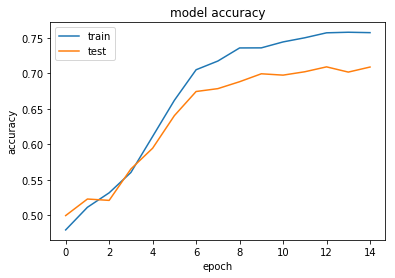

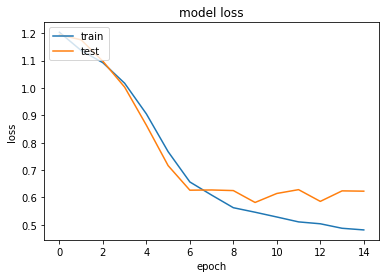

In [454]:
print('Vanilla lstm:')
plot_accuracy(vanilla_history)
plot_loss(vanilla_history)

Stacked lstm:


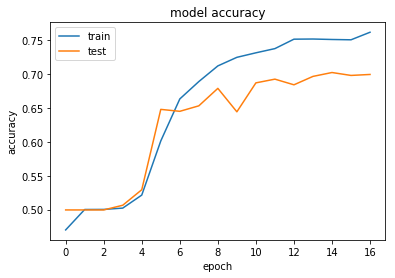

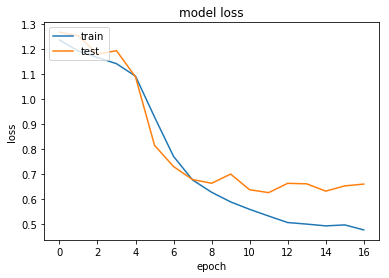

In [455]:
print('Stacked lstm:')
plot_accuracy(stacked_history)
plot_loss(stacked_history)

Bi lstm:


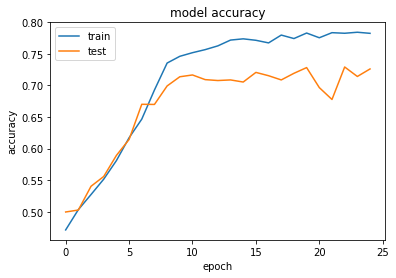

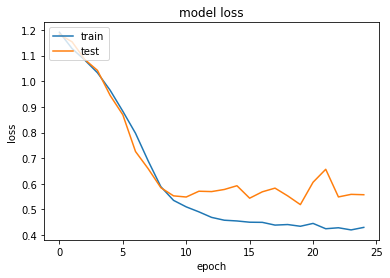

In [456]:
print('Bi lstm:')
plot_accuracy(bi_lstm_history)
plot_loss(bi_lstm_history)

In [457]:
from sklearn.metrics import classification_report

labels_true = pred_tensor_to_labels(y_test)
# vanilla
y_pred_vanilla = vanilla.predict(X_test)
labels_pred_vanilla = pred_tensor_to_labels(y_pred_vanilla)
# stacked
y_pred_stacked = stacked.predict(X_test)
labels_pred_stacked = pred_tensor_to_labels(y_pred_stacked)
# bilstm
y_pred_bi_lstm = bi_lstm.predict(X_test)
labels_pred_bi_lstm = pred_tensor_to_labels(y_pred_bi_lstm)

In [516]:
# removing U label for accuracy measures
true_labels_no_U = []
vanilla_pred_no_U = []
stacked_pred_no_U = []
bi_lstm_pred_no_U = []
for true_label, pred_vanilla, pred_stacked, pred_bi_lstm in zip(labels_true, labels_pred_vanilla, labels_pred_stacked, labels_pred_bi_lstm):
    if true_label != 'U':
        true_labels_no_U.append(true_label)
        vanilla_pred_no_U.append(pred_vanilla)
        stacked_pred_no_U.append(pred_stacked)
        bi_lstm_pred_no_U.append(pred_bi_lstm)

In [517]:
# ACCURACY
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# counted only for NB, PB, B true labels (U label is omitted)
acc_vanilla = accuracy_score(true_labels_no_U, vanilla_pred_no_U)
acc_stacked = accuracy_score(true_labels_no_U, stacked_pred_no_U)
acc_bi_lstm = accuracy_score(true_labels_no_U, bi_lstm_pred_no_U)
print("Accuracies:\nvanilla - {},\n stacked - {},\n bi-lstm - {}".format(acc_vanilla, acc_stacked, acc_bi_lstm))

Accuracies:
vanilla - 0.4391056137012369,
 stacked - 0.422930542340628,
 bi-lstm - 0.4581351094196004


vanilla model:

Normalized confusion matrix
[[0.4  0.21 0.36 0.03]
 [0.21 0.38 0.26 0.15]
 [0.17 0.21 0.6  0.03]
 [0.   0.   0.01 0.98]]


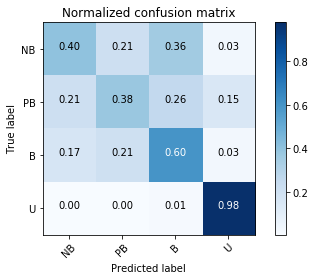

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.53      0.40      0.46       745
          NB       0.56      0.38      0.45       858
          PB       0.38      0.60      0.47       499
           U       0.00      0.00      0.00         0

   micro avg       0.44      0.44      0.44      2102
   macro avg       0.37      0.34      0.34      2102
weighted avg       0.51      0.44      0.46      2102



In [531]:
print('vanilla model:\n')
print(cnf_matrix(labels_true, labels_pred_vanilla, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, vanilla_pred_no_U)

stacked model:

Normalized confusion matrix
[[0.36 0.14 0.46 0.04]
 [0.16 0.29 0.4  0.15]
 [0.09 0.13 0.75 0.03]
 [0.   0.   0.02 0.98]]


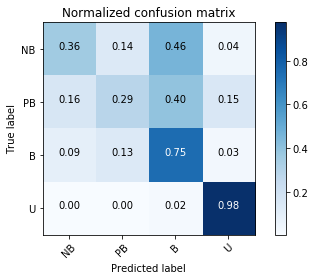

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.59      0.36      0.45       745
          NB       0.60      0.29      0.39       858
          PB       0.35      0.75      0.48       499
           U       0.00      0.00      0.00         0

   micro avg       0.42      0.42      0.42      2102
   macro avg       0.39      0.35      0.33      2102
weighted avg       0.54      0.42      0.43      2102



In [532]:
print('stacked model:\n')
print(cnf_matrix(labels_true, labels_pred_stacked, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, stacked_pred_no_U)

bi lstm model:

Normalized confusion matrix
[[2.58e-01 3.42e-01 3.96e-01 4.03e-03]
 [7.93e-02 5.15e-01 2.76e-01 1.29e-01]
 [4.41e-02 2.89e-01 6.59e-01 8.02e-03]
 [0.00e+00 4.77e-04 5.24e-03 9.94e-01]]


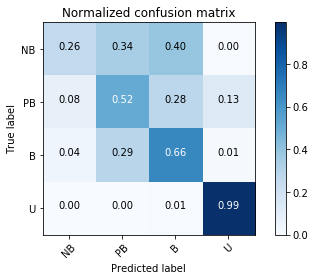

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.26      0.37       745
          NB       0.53      0.52      0.52       858
          PB       0.38      0.66      0.48       499
           U       0.00      0.00      0.00         0

   micro avg       0.46      0.46      0.46      2102
   macro avg       0.40      0.36      0.34      2102
weighted avg       0.55      0.46      0.46      2102



In [533]:
print('bi lstm model:\n')
print(cnf_matrix(labels_true, labels_pred_bi_lstm, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, bi_lstm_pred_no_U)

In [168]:
error_eval = []
eval_bow_dict = eval_bow.most_common(len(eval_bow))
for token, freq in eval_bow_dict:
    if token not in model:
        error_eval.append((token,freq))

In [222]:
for punct in punctuation_signs:
    if punct not in model:
        print(punct,' not in the model')

In [ ]:
from scipy.stats import ttest_ind